###3.1. Setup & data prep (paths, unzip, split, folder structure)

In [1]:
# ==========================================================
# 0) Mount Google Drive (required for CSV and ZIP access)
# ==========================================================
from google.colab import drive
drive.mount('/content/drive')

print("Drive mounted.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted.


In [2]:
# ==========================================================
# YOLOv8 CLASSIFICATION – E-waste project
# ==========================================================
!pip install -q ultralytics

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------------------------------------------
# 1) Paths & basic config
# ----------------------------------------------------------
WORK_DIR = '/content/drive/MyDrive/Colab Notebooks/ComputerVision'
CSV_PATH = os.path.join(WORK_DIR, 'image_labels.csv')


PROJECT_DIR = os.path.join(WORK_DIR, "experiments")
EXP_NAME_YOLO = "yolo_cls_noaug_v1"

# zip + local dir
ZIP_PATH = os.path.join(
    WORK_DIR,
    'Dataset Consolidado.zip'
)
LOCAL_RAW_DATA_DIR = "/content/Dataset_Consolidado_LOCAL"

print("WORK_DIR:", WORK_DIR)
print("CSV_PATH:", CSV_PATH)
print("ZIP_PATH:", ZIP_PATH)
print("LOCAL_RAW_DATA_DIR:", LOCAL_RAW_DATA_DIR)



WORK_DIR: /content/drive/MyDrive/Colab Notebooks/ComputerVision
CSV_PATH: /content/drive/MyDrive/Colab Notebooks/ComputerVision/image_labels.csv
ZIP_PATH: /content/drive/MyDrive/Colab Notebooks/ComputerVision/Dataset Consolidado.zip
LOCAL_RAW_DATA_DIR: /content/Dataset_Consolidado_LOCAL


#### unzip and copoy in local

In [4]:

# ----------------------------------------------------------
# 2) Unzip dataset from Drive to local /content (fast I/O)
# ----------------------------------------------------------
if not os.path.exists(LOCAL_RAW_DATA_DIR):
    print("Unzipping dataset to local VM storage...")
    !unzip -q "$ZIP_PATH" -d /content/

    !mv "/content/Dataset Consolidado" "$LOCAL_RAW_DATA_DIR"
    print("Unzip complete.")
else:
    print("Local dataset already exists — fast mode enabled.")

# ----------------------------------------------------------
# 3) Load CSV and rewrite paths from Drive → local
# ----------------------------------------------------------
df_all = pd.read_csv(CSV_PATH)
print("Total images in CSV:", len(df_all))

RAW_DATA_DIR_DRIVE = os.path.join(WORK_DIR, 'Dataset Consolidado')

def convert_drive_to_local(path):
    """
    Convert a path that points to the Drive-based dataset
    into the equivalent path inside LOCAL_RAW_DATA_DIR (/content/...).
    """
    return path.replace(RAW_DATA_DIR_DRIVE, LOCAL_RAW_DATA_DIR)

df_all['image_path'] = df_all['image_path'].apply(convert_drive_to_local)

print("Example local path:", df_all.iloc[0]['image_path'])
display(df_all.head())

Local dataset already exists — fast mode enabled.
Total images in CSV: 59001
Example local path: /content/Dataset_Consolidado_LOCAL/Papel y Carton/paper_2091.jpg


image_path           label
0  /content/Dataset_Consolidado_LOCAL/Papel y Car...  Papel y Carton
1  /content/Dataset_Consolidado_LOCAL/Papel y Car...  Papel y Carton
2  /content/Dataset_Consolidado_LOCAL/Papel y Car...  Papel y Carton
3  /content/Dataset_Consolidado_LOCAL/Papel y Car...  Papel y Carton
4  /content/Dataset_Consolidado_LOCAL/Papel y Car...  Papel y Carton

### 2. Stratigied train val test split

In [5]:
# ----------------------------------------------------------
# 4) Stratified train/val/test split
# ----------------------------------------------------------
SEED = 42
TRAIN_FRAC = 0.8
VAL_FRAC   = 0.1
TEST_FRAC  = 0.1

rng = np.random.default_rng(SEED)

train_idx = []
val_idx   = []
test_idx  = []

for label, group in df_all.groupby('label', sort=False):
    idx = group.index.to_numpy()
    rng.shuffle(idx)
    n_total = len(idx)

    n_train = int(n_total * TRAIN_FRAC)
    n_val   = int(n_total * VAL_FRAC)
    n_test  = n_total - n_train - n_val

    train_idx.extend(idx[:n_train])
    val_idx.extend(idx[n_train:n_train + n_val])
    test_idx.extend(idx[n_train + n_val:])

df_train = df_all.loc[train_idx].reset_index(drop=True)
df_val   = df_all.loc[val_idx].reset_index(drop=True)
df_test  = df_all.loc[test_idx].reset_index(drop=True)

print("Train images:", len(df_train))
print("Val images  :", len(df_val))
print("Test images :", len(df_test))


Train images: 47195
Val images  : 5896
Test images : 5910


### 3. Build YOLO model

In [6]:
# ----------------------------------------------------------
# 5) Build YOLOv8 CLASSIFICATION directory structure
#    /content/yolo_ewaste_cls/{train,val,test}/{class_name}/image.jpg
# ----------------------------------------------------------
YOLO_DATA_DIR = "/content/yolo_ewaste_cls"
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(YOLO_DATA_DIR, split)
    os.makedirs(split_dir, exist_ok=True)

# Get sorted class names from the labels
class_names = sorted(df_all['label'].unique())
class_to_index = {c: i for i, c in enumerate(class_names)}
index_to_class = {i: c for c, i in class_to_index.items()}

print("Number of classes:", len(class_names))
print("Sample classes:", class_names[:10])

def populate_split_folder(df_split, split_name):
    """
    For each row in df_split, create:
    YOLO_DATA_DIR/split_name/label/image_filename
    using symlinks to avoid copying the whole dataset.
    """
    split_root = os.path.join(YOLO_DATA_DIR, split_name)
    for _, row in df_split.iterrows():
        img_path = row['image_path']
        label    = str(row['label'])

        # Class folder for this split
        class_dir = os.path.join(split_root, label)
        os.makedirs(class_dir, exist_ok=True)

        # Target path (symlink)
        filename = os.path.basename(img_path)
        dst_path = os.path.join(class_dir, filename)

        # Create symlink if it doesn't exist
        if not os.path.exists(dst_path):
            try:
                os.symlink(img_path, dst_path)
            except FileExistsError:
                pass  # in case of race / reruns

print("Populating YOLO train/val/test folders with symlinks...")
populate_split_folder(df_train, 'train')
populate_split_folder(df_val,   'val')
populate_split_folder(df_test,  'test')
print("Done.")


Number of classes: 12
Sample classes: ['Bio organico', 'Envase Plasticos', 'Papel y Carton', 'Reciclables Varios Cigarro', 'Reciclables Varios Electronicos', 'Reciclables Varios Madera', 'Reciclables Varios Metal', 'Reciclables Varios Otros', 'Reciclables Varios Plastico', 'Reciclables Varios Textiles']
Populating YOLO train/val/test folders with symlinks...
Done.


### 4. Train YOLOv8 classifier

In [6]:
# ==========================================================
# YOLOv8 CLASSIFICATION TRAINING
# ==========================================================

from ultralytics import YOLO

# Small, fast classification model
model = YOLO('yolov8n-cls.pt')

EXP_NAME_YOLO = "yolo_cls_noaug_v1"
PROJECT_DIR = os.path.join(WORK_DIR, "experiments")

print("Starting YOLOv8 classification training...")

model.train(
    data=YOLO_DATA_DIR,   # root with train/val/test
    epochs=20,            # adjust if you want more/less
    imgsz=224,            # same as ResNet input
    batch=64,             # increase if GPU memory allows
    workers=2,            # num dataloader workers
    project=PROJECT_DIR,
    name=EXP_NAME_YOLO,
    val=True              # run validation during training
)

print("Training complete.")


Streaming output truncated to the last 5000 lines.
train: /content/yolo_ewaste_cls/train/Todo lo demás/img_1743.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/yolo_ewaste_cls/train/Todo lo demás/img_1743.jpg'
train: /content/yolo_ewaste_cls/train/Todo lo demás/img_1746.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/yolo_ewaste_cls/train/Todo lo demás/img_1746.jpg'
train: /content/yolo_ewaste_cls/train/Todo lo demás/img_1747.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/yolo_ewaste_cls/train/Todo lo demás/img_1747.jpg'
train: /content/yolo_ewaste_cls/train/Todo lo demás/img_1748.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/yolo_ewaste_cls/train/Todo lo demás/img_1748.jpg'
train: /content/yolo_ewaste_cls/train/Todo lo demás/img_1749.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/content/yolo_ewaste_cls/train/Tod

In [6]:
!find /content/yolo_ewaste_cls/train -type f | wc -l
!find /content/yolo_ewaste_cls/val -type f | wc -l


0
0


In [14]:
print("CSV train size:", len(df_train))
print("CSV val size:", len(df_val))


CSV train size: 47195
CSV val size: 5896


In [15]:
import os
exists = df_test['image_path'].apply(os.path.exists)
print("Total test rows in CSV:", len(df_test))
print("Files that actually exist:", exists.sum())
print("Missing files:", (~exists).sum())


Total test rows in CSV: 5910
Files that actually exist: 2097
Missing files: 3813


### 5. Evaluate YOLO on the test set (classification report + confusion matrix)


In [11]:
DRIVE_BASE = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Dataset Consolidado"

df_all["image_path"] = df_all["image_path"].apply(
    lambda p: str(p).replace("/content/Dataset_Consolidado_LOCAL", DRIVE_BASE)
)


In [12]:
sum(df_all['image_path'].apply(os.path.exists))


59001

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV: /content/drive/MyDrive/Colab Notebooks/ComputerVision/image_labels.csv
Dataset folder: /content/drive/MyDrive/Colab Notebooks/ComputerVision/Dataset Consolidado

Sample fixed paths:


image_path           label
0  /content/drive/MyDrive/Colab Notebooks/Compute...  Papel y Carton
1  /content/drive/MyDrive/Colab Notebooks/Compute...  Papel y Carton
2  /content/drive/MyDrive/Colab Notebooks/Compute...  Papel y Carton
3  /content/drive/MyDrive/Colab Notebooks/Compute...  Papel y Carton
4  /content/drive/MyDrive/Colab Notebooks/Compute...  Papel y Carton


Total images in CSV: 59001
Images actually found on Drive: 59001

Test set size (CSV): 5910

Usable test images: 5910

Loading model: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/yolo_cls_noaug_v1/weights/best.pt

Running evaluation...
  Processing 0 → 255
  Processing 256 → 511
  Processing 512 → 767
  Processing 768 → 1023
  Processing 1024 → 1279
  Processing 1280 → 1535
  Processing 1536 → 1791
  Processing 1792 → 2047
  Processing 2048 → 2303
  Processing 2304 → 2559
  Processing 2560 → 2815
  Processing 2816 → 3071
  Processing 3072 → 3327
  Processing 3328 → 3583
  Processing 3584 → 3839
  Processing 3840 → 4095
  Processing 4096 → 4351
  Processing 4352 → 4607
  Processing 4608 → 4863
  Processing 4864 → 5119
  Processing 5120 → 5375
  Processing 5376 → 5631
  Processing 5632 → 5887
  Processing 5888 → 5909

=== YOLOv8 CLASSIFICATION REPORT (TEST) ===

                                 precision    recall  f1-score   support

                   Bio organico

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


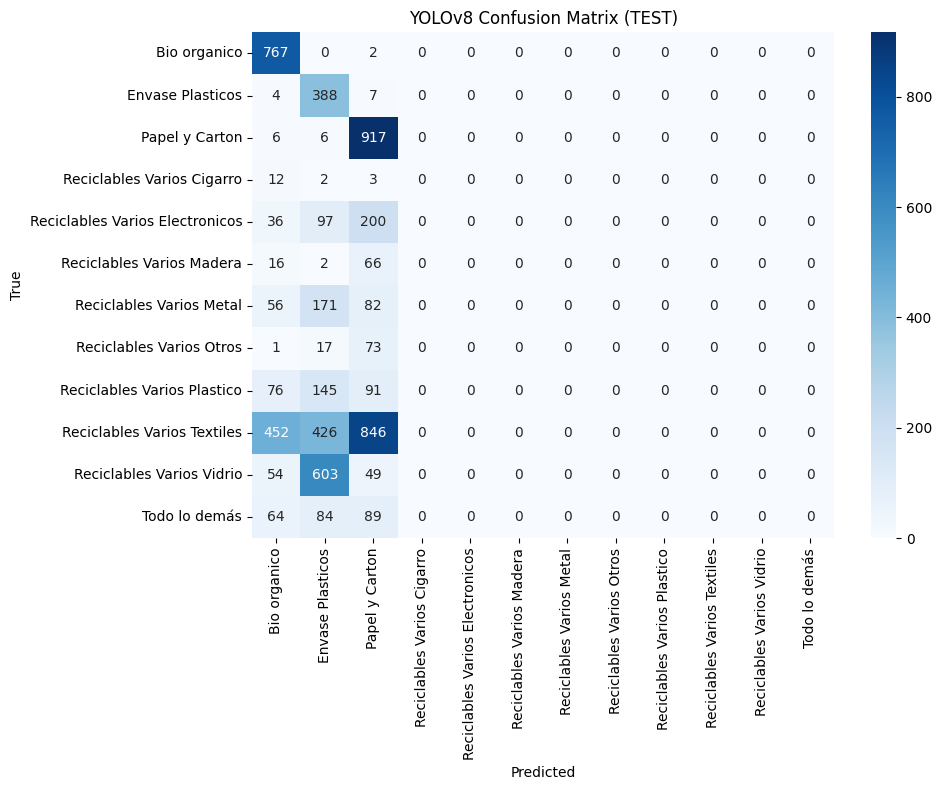


Overall TEST accuracy: 0.3506


In [13]:
# ==========================================================
# FULL EVALUATION PIPELINE (NO TRAINING)
# Fixes paths, rebuilds split, evaluates trained model
# ==========================================================

# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Install ultralytics
!pip install -q ultralytics

# 3) Imports
import os
import numpy as np
import pandas as pd
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import torch

# ----------------------------------------------------------
# 4) DEFINE PATHS
# ----------------------------------------------------------
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/ComputerVision"
CSV_PATH = os.path.join(WORK_DIR, "image_labels.csv")
PROJECT_DIR = os.path.join(WORK_DIR, "experiments")
EXP_NAME_YOLO = "yolo_cls_noaug_v1"

DATASET_DRIVE_DIR = os.path.join(WORK_DIR, "Dataset Consolidado")

print("CSV:", CSV_PATH)
print("Dataset folder:", DATASET_DRIVE_DIR)

# ----------------------------------------------------------
# 5) LOAD CSV + FIX PATHS
# ----------------------------------------------------------
df_all = pd.read_csv(CSV_PATH)

def fix_path(p):
    """Convert temporary Colab paths → Drive paths."""
    p = str(p)
    return p.replace("/content/Dataset_Consolidado_LOCAL", DATASET_DRIVE_DIR)

df_all["image_path"] = df_all["image_path"].apply(fix_path)

# Sanity check
print("\nSample fixed paths:")
display(df_all.head())

# Count how many files actually exist
exists = df_all["image_path"].apply(os.path.exists)
print("\nTotal images in CSV:", len(df_all))
print("Images actually found on Drive:", exists.sum())

# ----------------------------------------------------------
# 6) REBUILD TRAIN/VAL/TEST SPLIT (must match training)
# ----------------------------------------------------------
SEED = 42
TRAIN_FRAC = 0.8
VAL_FRAC   = 0.1
TEST_FRAC  = 0.1

rng = np.random.default_rng(SEED)
train_idx, val_idx, test_idx = [], [], []

for label, group in df_all.groupby("label", sort=False):
    idx = group.index.to_numpy()
    rng.shuffle(idx)

    n = len(idx)
    n_train = int(n * TRAIN_FRAC)
    n_val   = int(n * VAL_FRAC)
    n_test  = n - n_train - n_val

    train_idx.extend(idx[:n_train])
    val_idx.extend(idx[n_train:n_train+n_val])
    test_idx.extend(idx[n_train+n_val:])

df_test = df_all.loc[test_idx].reset_index(drop=True)

print("\nTest set size (CSV):", len(df_test))

# ----------------------------------------------------------
# 7) FILTER OUT MISSING TEST IMAGES
# ----------------------------------------------------------
valid_paths = []
valid_labels = []

class_names = sorted(df_all["label"].unique())
class_to_index = {c:i for i,c in enumerate(class_names)}

for path, label in zip(df_test["image_path"], df_test["label"]):
    if os.path.exists(path):
        valid_paths.append(path)
        valid_labels.append(class_to_index[label])
    else:
        print("[MISSING]", path)

valid_labels = np.array(valid_labels)

print("\nUsable test images:", len(valid_paths))

if len(valid_paths) == 0:
    raise RuntimeError("No test images found. Path conversion might be wrong.")

# ----------------------------------------------------------
# 8) LOAD TRAINED MODEL
# ----------------------------------------------------------
BEST_WEIGHTS = os.path.join(
    PROJECT_DIR, EXP_NAME_YOLO, "weights", "best.pt"
)

print("\nLoading model:", BEST_WEIGHTS)
model = YOLO(BEST_WEIGHTS)

# ----------------------------------------------------------
# 9) RUN EVALUATION IN SMALL BATCHES (MEMORY SAFE)
# ----------------------------------------------------------
print("\nRunning evaluation...")

all_probs = []
CHUNK = 256      # number of paths per predict() call
PRED_BATCH = 64  # YOLO internal batch size

for start in range(0, len(valid_paths), CHUNK):
    end = min(start + CHUNK, len(valid_paths))
    sub_paths = valid_paths[start:end]

    print(f"  Processing {start} → {end-1}")

    results = model.predict(
        source=sub_paths,
        imgsz=224,
        batch=PRED_BATCH,
        verbose=False
    )

    for r in results:
        all_probs.append(r.probs.data.cpu().numpy())

    del results
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

pred_probs = np.stack(all_probs)
pred_labels = np.argmax(pred_probs, axis=1)

# ----------------------------------------------------------
# 10) REPORT
# ----------------------------------------------------------
print("\n=== YOLOv8 CLASSIFICATION REPORT (TEST) ===\n")
print(classification_report(valid_labels, pred_labels, target_names=class_names))

cm = confusion_matrix(valid_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("YOLOv8 Confusion Matrix (TEST)")
plt.tight_layout()
plt.show()

acc = (valid_labels == pred_labels).mean()
print(f"\nOverall TEST accuracy: {acc:.4f}")


###Eval

Misclassification confidence histogram (YOLO)

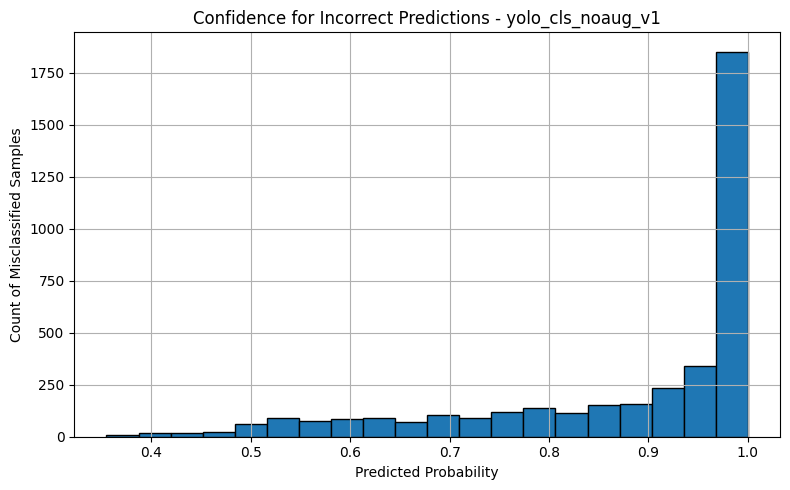

Number of misclassified samples: 3838


In [14]:
# ==========================================================
# YOLO – Misclassification Confidence Histogram (UPDATED)
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt

# true labels    -> valid_labels
# predicted      -> pred_labels
# probabilities  -> pred_probs

incorrect_idx = np.where(pred_labels != valid_labels)[0]

if len(incorrect_idx) == 0:
    print("No misclassifications found!")
else:
    # confidence of the predicted (wrong) class
    incorrect_conf = pred_probs[incorrect_idx, pred_labels[incorrect_idx]]

    plt.figure(figsize=(8, 5))
    plt.hist(incorrect_conf, bins=20, edgecolor='black')
    plt.title(f"Confidence for Incorrect Predictions - {EXP_NAME_YOLO}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count of Misclassified Samples")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Number of misclassified samples: {len(incorrect_idx)}")


Correct vs Incorrect confidence comparison

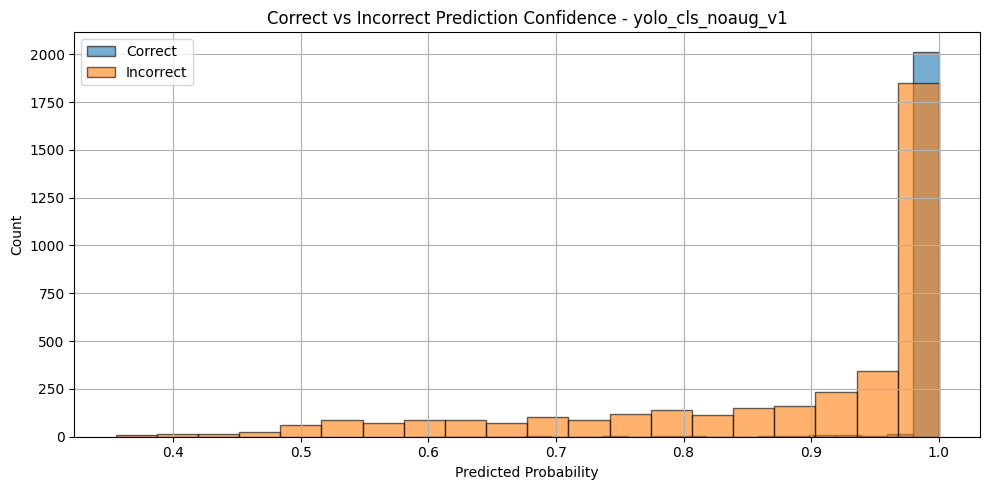

Correct predictions: 2072
Incorrect predictions: 3838


In [15]:
# ==========================================================
# YOLO – Correct vs Incorrect Prediction Confidence (UPDATED)
# ==========================================================

# correct and incorrect indices
correct_idx   = np.where(pred_labels == valid_labels)[0]
incorrect_idx = np.where(pred_labels != valid_labels)[0]

# confidence for correct predictions
correct_conf = pred_probs[correct_idx, pred_labels[correct_idx]]

# confidence for incorrect predictions
incorrect_conf = pred_probs[incorrect_idx, pred_labels[incorrect_idx]]

# Plot
plt.figure(figsize=(10, 5))
plt.hist(correct_conf,   bins=20, alpha=0.6, label="Correct",   edgecolor='black')
plt.hist(incorrect_conf, bins=20, alpha=0.6, label="Incorrect", edgecolor='black')
plt.title(f"Correct vs Incorrect Prediction Confidence - {EXP_NAME_YOLO}")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Correct predictions: {len(correct_idx)}")
print(f"Incorrect predictions: {len(incorrect_idx)}")


ROC curves for all classes (YOLO)

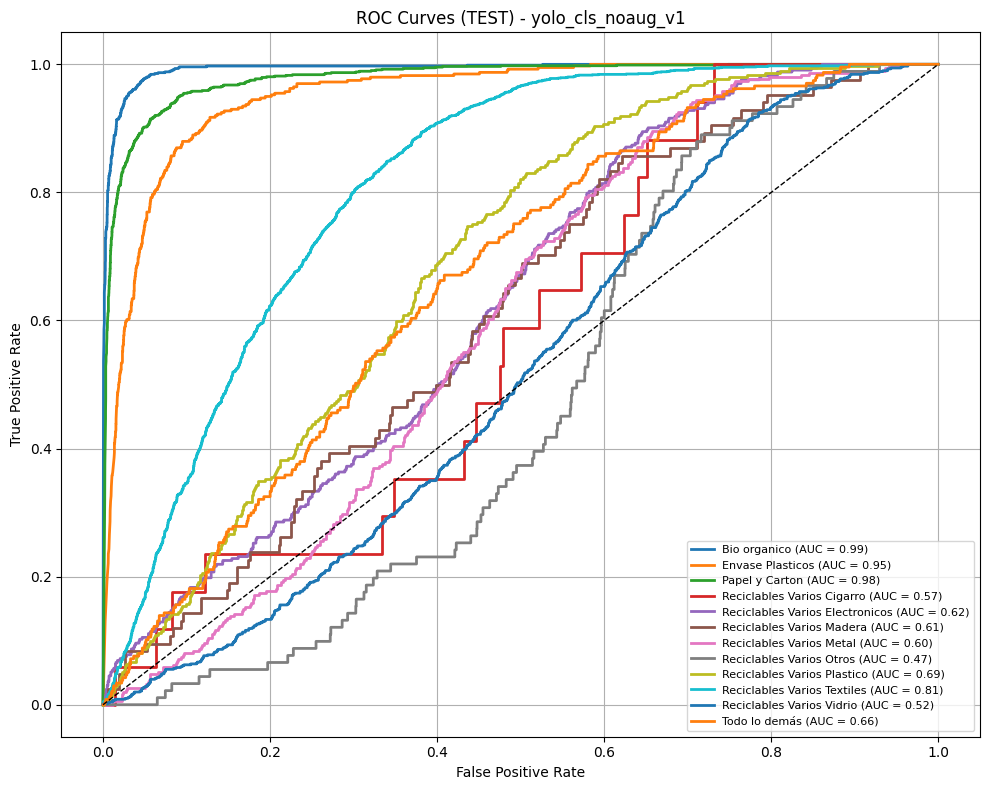

In [16]:
# ==========================================================
# YOLO – ROC Curves (one-vs-rest)  (UPDATED)
# ==========================================================
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = len(class_names)

# Binarize true labels: shape (N_test, num_classes)
y_true_bin = label_binarize(valid_labels, classes=range(num_classes))

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    # Calculate ROC for class i vs rest
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)

    class_name = class_names[i]
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Baseline chance curve
plt.plot([0, 1], [0, 1], "k--", lw=1)

plt.title(f"ROC Curves (TEST) - {EXP_NAME_YOLO}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


YOLO training curves over epochs

Reading training log from: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/yolo_cls_noaug_v1/results.csv

Head of results.csv:
   epoch     time  train/loss  metrics/accuracy_top1  metrics/accuracy_top5  \
0      1  1045.67     0.75757                0.94893                      1   
1      2  2082.80     0.15764                0.97375                      1   
2      3  3132.61     0.12636                0.97041                      1   
3      4  4164.46     0.10696                0.97613                      1   
4      5  5179.68     0.09365                0.98377                      1   

   val/loss    lr/pg0    lr/pg1    lr/pg2  
0   0.13934  0.000208  0.000208  0.000208  
1   0.08071  0.000395  0.000395  0.000395  
2   0.08792  0.000562  0.000562  0.000562  
3   0.07435  0.000532  0.000532  0.000532  
4   0.04991  0.000501  0.000501  0.000501  

Available columns in results.csv:
['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5',

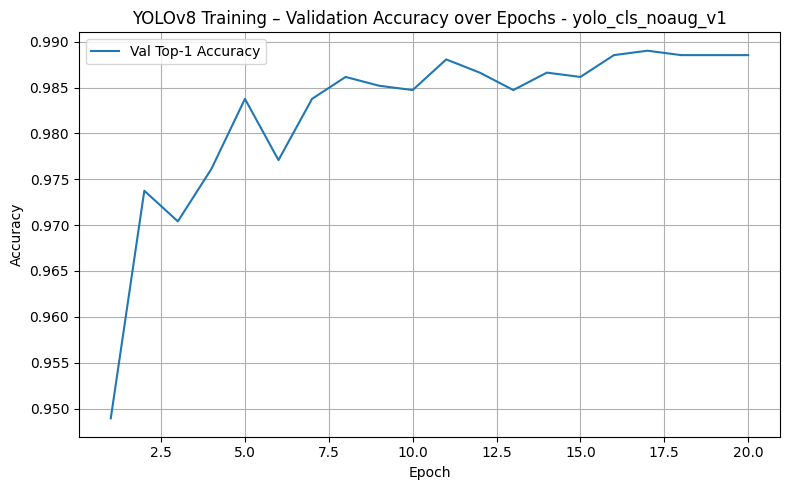

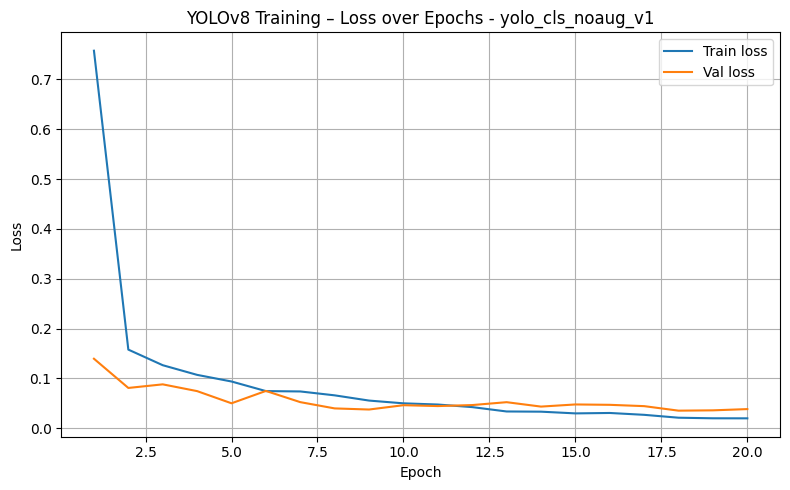

In [17]:
# ==========================================================
# YOLOv8 – Training Curves from results.csv (UPDATED)
# ==========================================================
import os
import pandas as pd
import matplotlib.pyplot as plt

# PROJECT_DIR and EXP_NAME_YOLO must already be defined
results_path = os.path.join(PROJECT_DIR, EXP_NAME_YOLO, "results.csv")
print("Reading training log from:", results_path)

df_hist = pd.read_csv(results_path)
print("\nHead of results.csv:")
print(df_hist.head())

print("\nAvailable columns in results.csv:")
print(df_hist.columns.tolist())

# ---- Accuracy curve (Top-1) ----
if "metrics/accuracy_top1" in df_hist.columns:
    acc_col = "metrics/accuracy_top1"
elif "metrics/accuracy" in df_hist.columns:
    acc_col = "metrics/accuracy"
else:
    raise KeyError("Could not find a Top-1 accuracy column in results.csv")

plt.figure(figsize=(8, 5))
plt.plot(df_hist["epoch"], df_hist[acc_col], label="Val Top-1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"YOLOv8 Training – Validation Accuracy over Epochs - {EXP_NAME_YOLO}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Loss curves (train & val) ----
train_loss_col = "train/loss"
val_loss_col   = "val/loss"

if train_loss_col not in df_hist.columns or val_loss_col not in df_hist.columns:
    raise KeyError("train/loss or val/loss not found in results.csv")

plt.figure(figsize=(8, 5))
plt.plot(df_hist["epoch"], df_hist[train_loss_col], label="Train loss")
plt.plot(df_hist["epoch"], df_hist[val_loss_col],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"YOLOv8 Training – Loss over Epochs - {EXP_NAME_YOLO}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Grids of correctly vs incorrectly classified images

Correctly classified test images   : 2072
Incorrectly classified test images : 3838


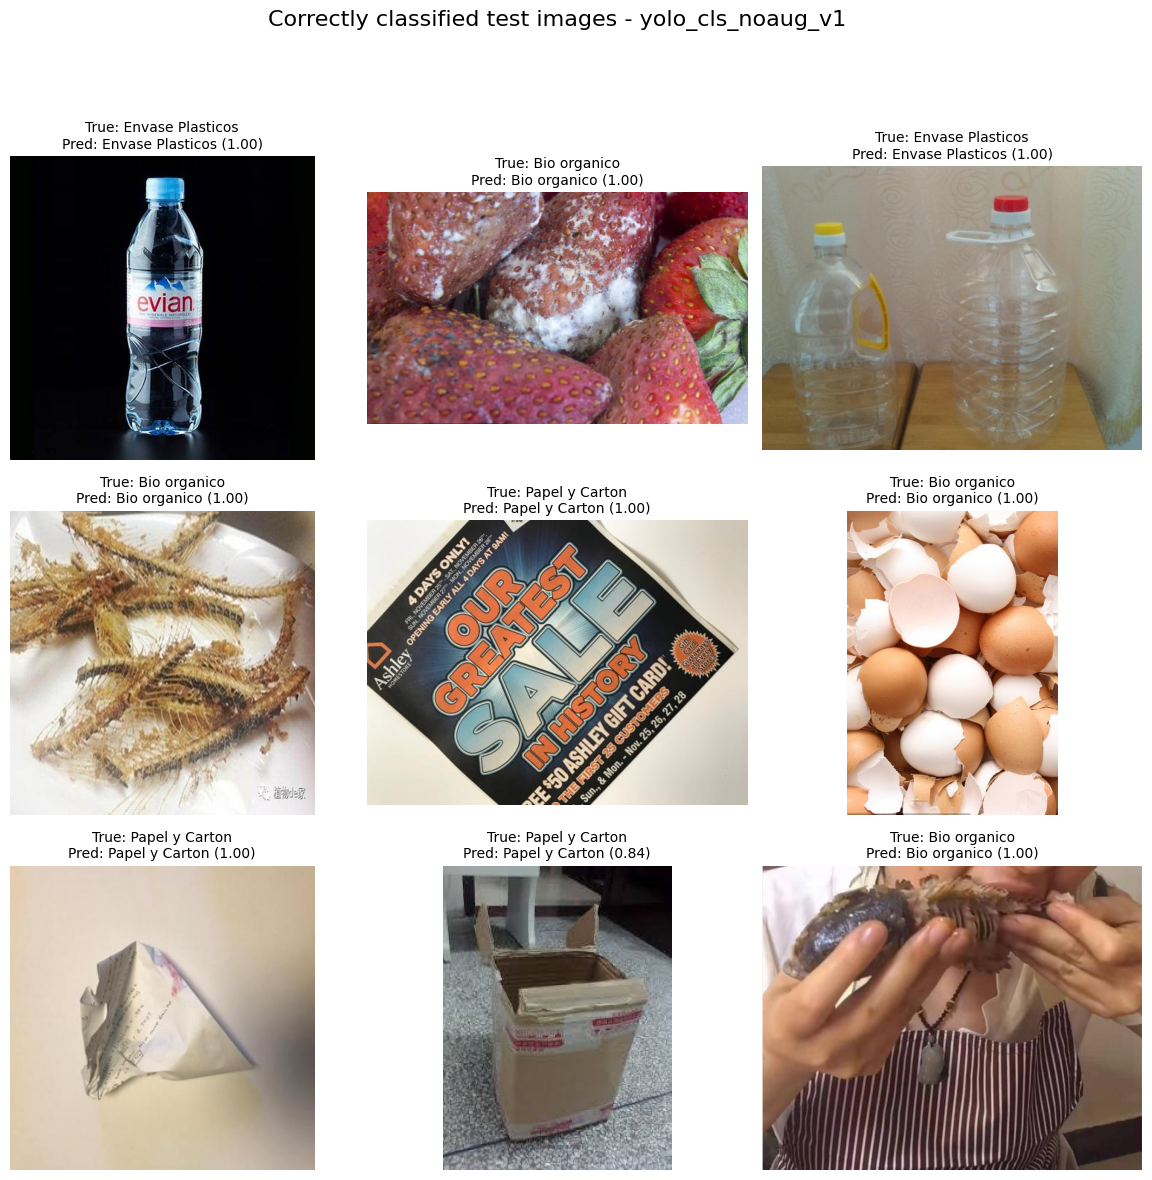

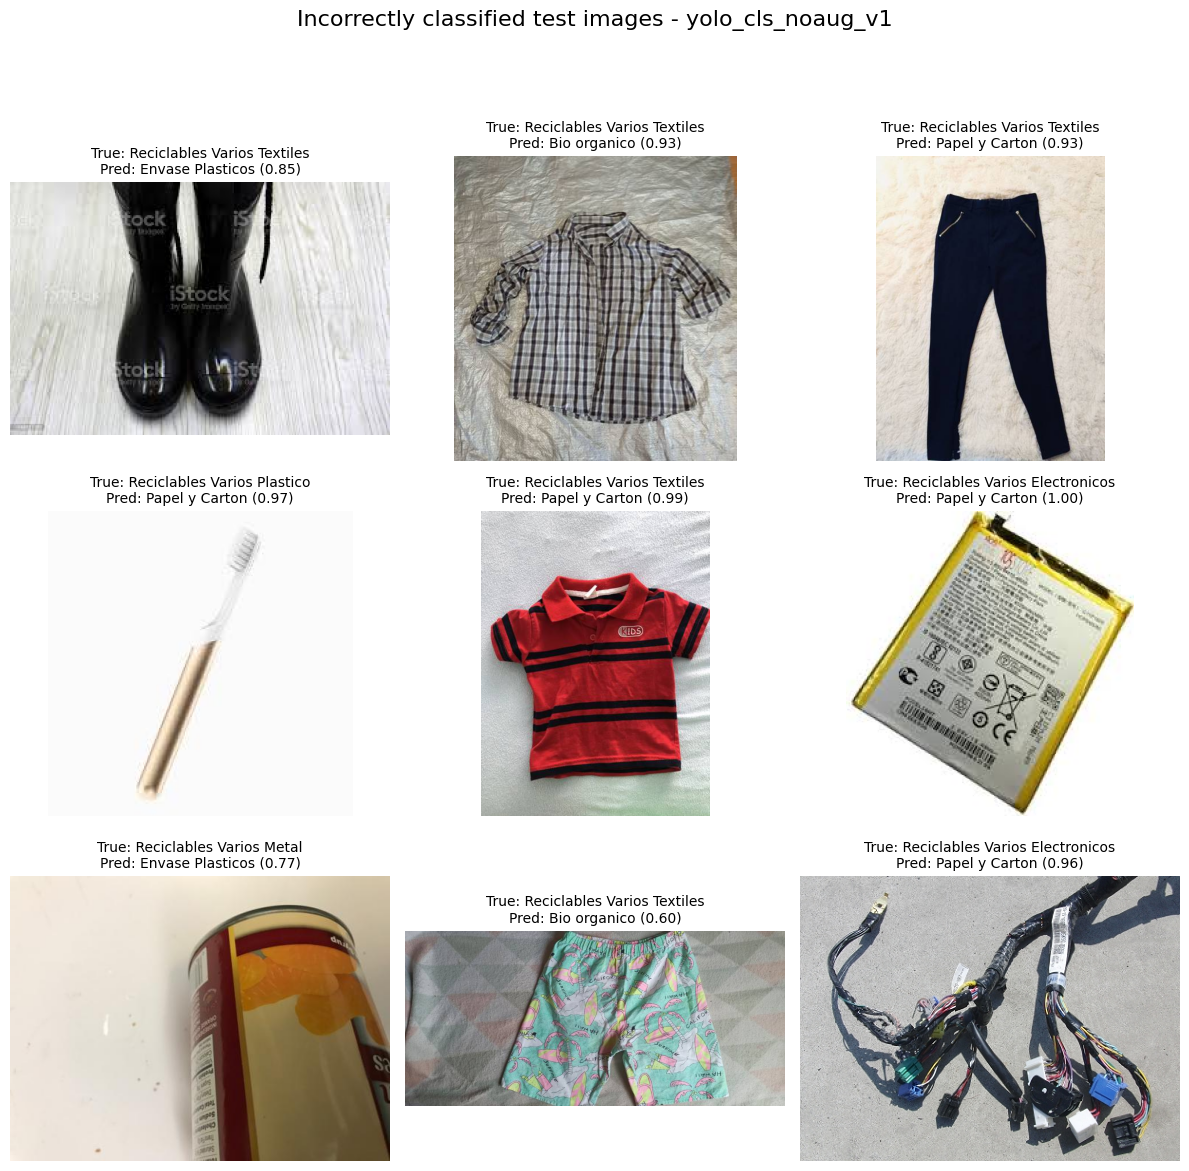

In [18]:
# ==========================================================
# YOLOv8 – Visualize Correct vs Incorrect Test Predictions (UPDATED)
# ==========================================================
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# index_to_class from class_names used in evaluation
index_to_class = {i: c for i, c in enumerate(class_names)}

# 1) Indices of correct / incorrect predictions
correct_idx   = np.where(pred_labels == valid_labels)[0]
incorrect_idx = np.where(pred_labels != valid_labels)[0]

print(f"Correctly classified test images   : {len(correct_idx)}")
print(f"Incorrectly classified test images : {len(incorrect_idx)}")

# Use only the usable test paths (aligned with valid_labels / pred_labels / pred_probs)
filepaths_test = np.array(valid_paths)

def show_examples(indices, n=9, title="Examples", index_to_class=None):
    """
    indices: array of indices in the *usable* test set
    n: number of images to display
    index_to_class: dict int -> class name
    """
    if len(indices) == 0:
        print(f"No examples to show for: {title}")
        return

    n = min(n, len(indices))
    chosen = np.random.choice(indices, size=n, replace=False)

    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 4, rows * 4))
    plt.suptitle(title, fontsize=16)

    for i, idx in enumerate(chosen, start=1):
        img_path = filepaths_test[idx]
        true_label_idx = valid_labels[idx]
        pred_label_idx = pred_labels[idx]
        probs = pred_probs[idx]
        pred_conf = probs[pred_label_idx]

        if index_to_class:
            true_label = index_to_class.get(true_label_idx, str(true_label_idx))
            pred_label = index_to_class.get(pred_label_idx, str(pred_label_idx))
        else:
            true_label = str(true_label_idx)
            pred_label = str(pred_label_idx)

        # Load image
        img = Image.open(img_path).convert("RGB")

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"True: {true_label}\nPred: {pred_label} ({pred_conf:.2f})",
            fontsize=10
        )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# 2) Show some CORRECT predictions
show_examples(
    correct_idx,
    n=9,
    title=f"Correctly classified test images - {EXP_NAME_YOLO}",
    index_to_class=index_to_class
)

# 3) Show some INCORRECT predictions
show_examples(
    incorrect_idx,
    n=9,
    title=f"Incorrectly classified test images - {EXP_NAME_YOLO}",
    index_to_class=index_to_class
)
